In [1]:
#!/usr/bin/env python

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob

In [2]:
# Parse ISO week format (e.g. "2020-W12") into a date (Monday of that ISO week)
def iso_week_to_date(iso_str):
    """
    Convert 'YYYY-Www' string into date.
    Example: "2020-W12" -> Monday of the 12th ISO week of 2020.
    """
    match = re.match(r"(\d{4})-W(\d{1,2})", iso_str)
    if not match:
        return None
    year, week = match.groups()
    year, week = int(year), int(week)
    return Week(year, week).monday()

In [3]:
# Read the 2010-2025 DK data
df = pd.read_csv("data/DK_2010_2025_posfrac.csv", dtype=str)
df["value"] = pd.to_numeric(df["PosFrac"])

# Create a 'date' column from 'year_Week'
df["date"] = df["year_Week"].apply(iso_week_to_date)
df['date'] = pd.to_datetime(df["date"])

print(df['date'])

0     2010-01-04
1     2010-01-11
2     2010-01-18
3     2010-01-25
4     2010-02-01
         ...    
793   2025-02-24
794   2025-03-03
795   2025-03-10
796   2025-03-17
797   2025-03-24
Name: date, Length: 798, dtype: datetime64[ns]


In [4]:
len(df['date'])

798

In [5]:
# Load in stan data:
csv_files = glob.glob('stan_output/estimate_seasonality_2025/*20250413085937*.csv')

print(csv_files)

fit = from_csv(csv_files)

['stan_output/estimate_seasonality_2025/sirs_seasonality_dt_fixeddelta-20250413085937_1.csv', 'stan_output/estimate_seasonality_2025/sirs_seasonality_dt_fixeddelta-20250413085937_4.csv', 'stan_output/estimate_seasonality_2025/sirs_seasonality_dt_fixeddelta-20250413085937_3.csv', 'stan_output/estimate_seasonality_2025/sirs_seasonality_dt_fixeddelta-20250413085937_2.csv']


In [6]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [7]:
print("Parameter means:")
for var in ['S0', 'logx_I0', 'sigma_obs', 'rho']:
#for var in ['S0', 'I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho', 'tau']:
    print(f"{var}: {fit.stan_variable(var).mean()}")

Parameter means:
S0: 0.5734098329166667
logx_I0: -2.599157754166667
sigma_obs: 0.017757171541666665
rho: 0.019284344875


In [8]:
# Extract confidence intervals using arviz

import arviz as az

idata = az.from_cmdstanpy(fit)
for var in ['S0', 'logx_I0', 'sigma_obs', 'rho']:
    hpd = az.hdi(idata, var_names=[var], hdi_prob=0.95)

    print(f"{var}: {fit.stan_variable(var).mean()}" + "\t\t" + f"[{np.float64(hpd[var][0])} ; {np.float64(hpd[var][1])}]")
    if var=="delta":
        print(f"1/{var}: {(1/52)*1/fit.stan_variable(var).mean()} years" + "\t\t" + f"[{(1/52)*1/np.float64(hpd[var][1])} ; {(1/52)*1/np.float64(hpd[var][0])}]")

S0: 0.5734098329166667		[0.566616 ; 0.580148]
logx_I0: -2.599157754166667		[-2.63783 ; -2.56469]
sigma_obs: 0.017757171541666665		[0.0166541 ; 0.0189125]
rho: 0.019284344875		[0.018633 ; 0.0199669]


I0 posterior mean +- sd: 0.001445 +- 0.000067


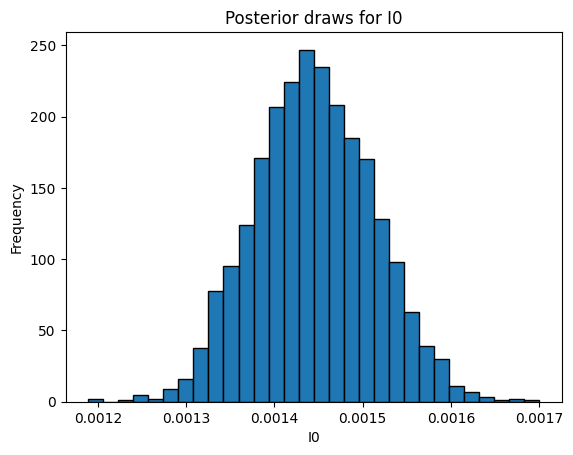

In [9]:
# Visualize draws for variable:
#var = 'sigma_obs'
#var = 'rho'
#var = 'beta0'
#var = 'betaphase'
#var = 'dbeta'
#var = 'delta'
var = 'I0'
#var = 'S0'
#var = 'x_I0'
#var = 'logx_I0'

v_samples = fit.stan_variable(var)

# Mean and standard deviation:
mean_v = v_samples.mean()
sd_v = v_samples.std()

print(f"{var} posterior mean +- sd: {mean_v:.6f} +- {sd_v:.6f}")
if var=='delta':
    print(f"1/(mean({var})) = {1/mean_v:.3f} weeks = {(1/52)*1/mean_v:.3f} years")
    print(f"+ standard deviation: 1/(mean({var})) = {1/(mean_v+sd_v):.3f} weeks = {(1/52)*1/(mean_v+sd_v):.3f} years")
    print(f"- standard deviation: 1/(mean({var})) = {1/(mean_v-sd_v):.3f} weeks = {(1/52)*1/(mean_v-sd_v):.3f} years")

plt.hist(v_samples, bins=30, edgecolor='k')
plt.title("Posterior draws for " + var)
plt.xlabel(var)
plt.ylabel("Frequency")
plt.show()


52


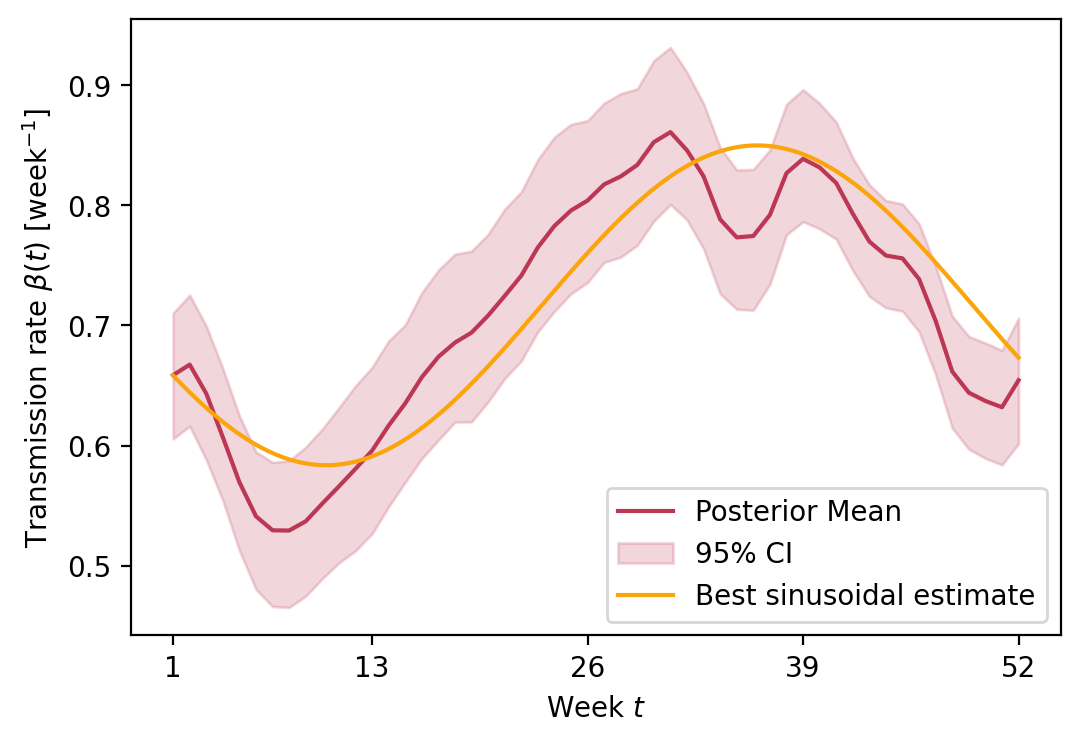

Mean of variable: 0.7098189873557691


In [10]:
# Nicer beta plot:
import matplotlib.cm as cm

#var = "Ifit"
var = "beta"

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

############

color = plt.cm.inferno(0.5)

# S_draws.shape = (num_draws, N + Npred)
mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile

# Let's assume you just want a simple plot of time index vs. S
time_idx = np.arange(1, v_draws.shape[1] + 1)  # 1..(N+Npred)

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(time_idx, mean_v, label='Posterior Mean', color=color)

plt.fill_between(time_idx, lower_v, upper_v, color=color, alpha=0.2, label='95% CI')
plt.xlabel(r'Week $t$')
plt.ylabel(r'Transmission rate $\beta(t)$ [week$^{-1}$]')
#plt.title('Posterior Mean and 95% CI for ' + var)


ts = np.linspace(1, 52, 1000)
beta0 = 0.7167610620833333
dbeta = 0.1855407425
betaphase = 3.5961723291666665
beta_t = beta0 * (1 + dbeta * np.sin(2*np.pi*(ts-1)/52 + betaphase))

plt.plot(ts, beta_t, label='Best sinusoidal estimate', color= plt.cm.inferno(0.8))

#plt.axvline(10.27)

plt.xticks([1, 13, 26, 39, 52])
#plt.ylim([0, 1/(10 * 52)])
plt.legend()
plt.show()
print(f"Mean of variable: {np.mean(mean_v)}")

1043


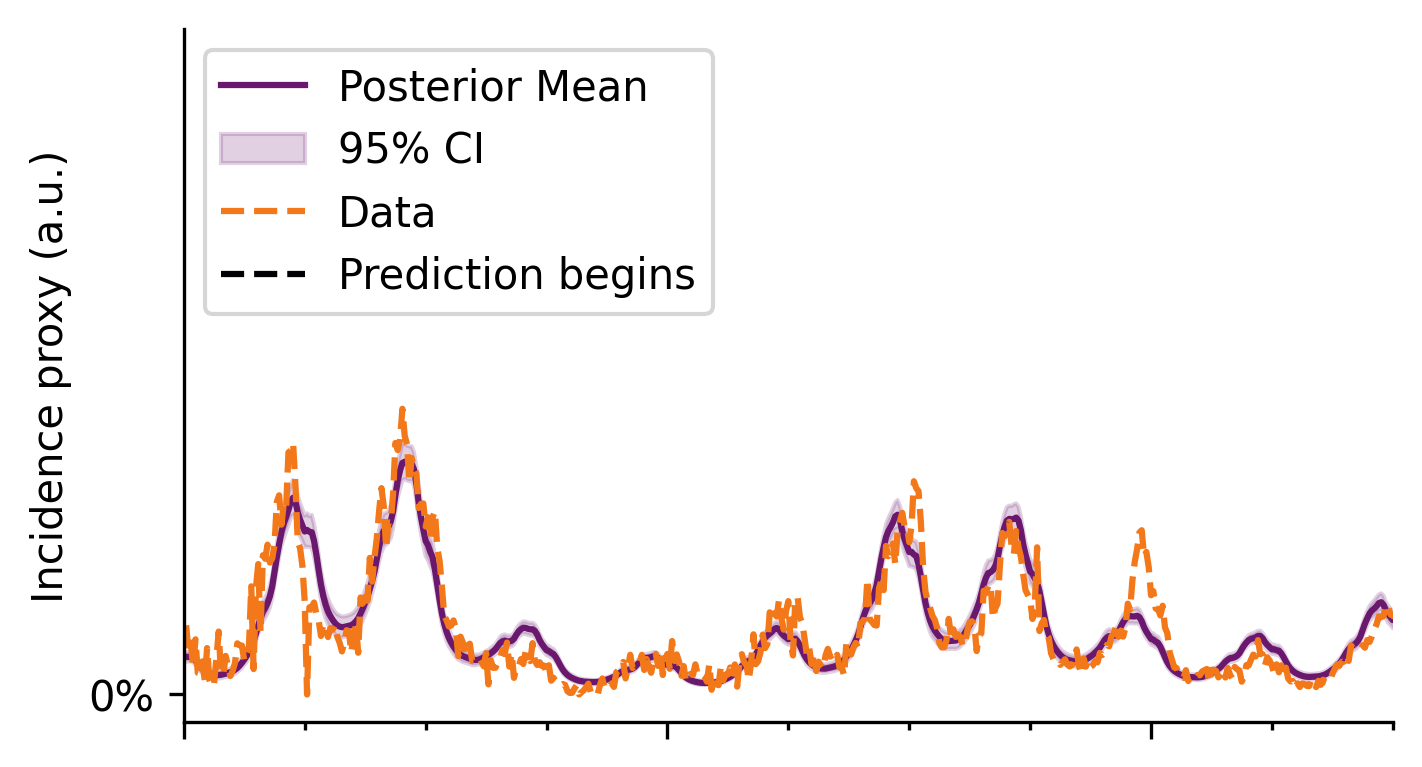

In [11]:
var = "Ifit"

v_draws = fit.stan_variable(var)
print(v_draws.shape[1])

plt.figure(figsize=(5.2, 3), dpi=300)

############

# S_draws.shape = (num_draws, N + Npred)
mean_v = np.mean(v_draws, axis=0)  # average over draws
lower_v = np.percentile(v_draws, 2.5, axis=0)  # 2.5% quantile
upper_v = np.percentile(v_draws, 97.5, axis=0) # 97.5% quantile

time_fit = np.arange(1, v_draws.shape[1] + 1)/52 + 2010
time_data = np.arange(1, len(df['value']) + 1)/52 + 2010

plt.plot(time_fit, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))


plt.fill_between(time_fit, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

plt.plot(time_data, df['value'], "--", label="Data", color=plt.cm.inferno(0.7))

prediction_start_date = time_data[-1]+1/52
color = plt.cm.inferno(0.0)
plt.axvline(prediction_start_date, ls="--", color=color, label="Prediction begins")

plt.xticks(np.arange(2010,2035))
xticklabels = []
ax=plt.gca()
n=4
for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if i % n == 0:
        tick.tick1line.set_markersize(4)  # tick length
        tick.tick2line.set_markersize(4)
        #xticklabels.append(i+2010)
        xticklabels.append('')
    else:
        tick.tick1line.set_markersize(2)  # tick length
        tick.tick2line.set_markersize(2)
        xticklabels.append('')

plt.xticks(np.arange(2010,2035), labels=xticklabels)
plt.yticks([0], labels=['0%'])

plt.ylabel("Incidence proxy (a.u.)")
plt.legend(loc="upper left")

plt.ylim([-0.021, 0.5])
plt.xlim([2010, 2020])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


2010-01-04 00:00:00
[Timestamp('2010-01-05 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2026-01-01 00:00:00'), Timestamp('2028-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00')]


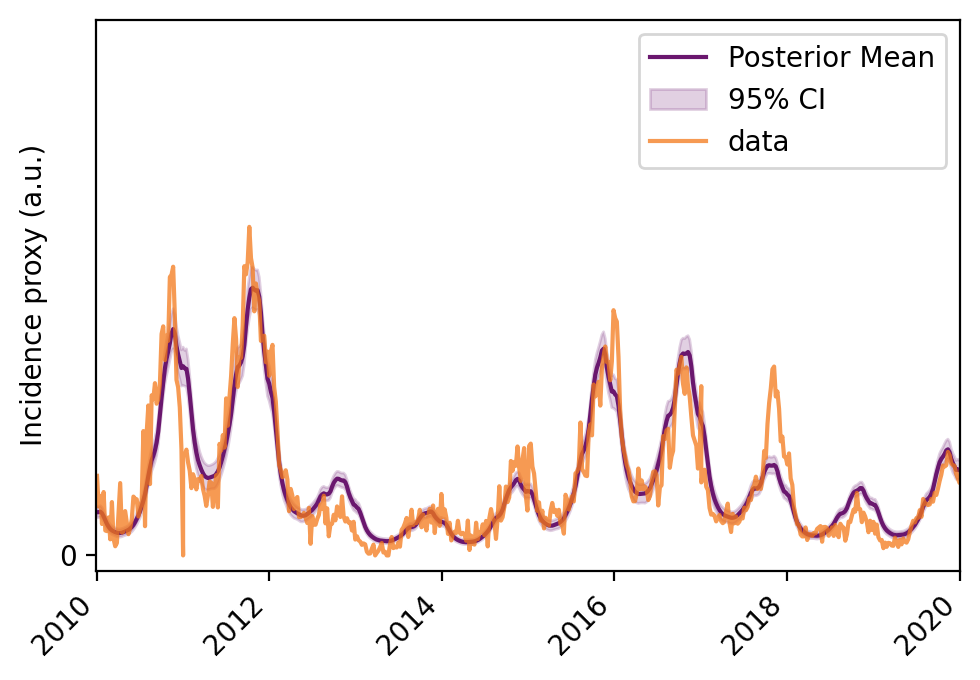

In [12]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

start_date = df["date"].iloc[0]
print(start_date)
n_time_points = v_draws.shape[1]
time_axis = pd.date_range(start=start_date, periods=n_time_points, freq="W-MON")

mean_v = np.mean(v_draws, axis=0)
lower_v = np.percentile(v_draws, 2.5, axis=0)
upper_v = np.percentile(v_draws, 97.5, axis=0)

plt.figure(figsize=(5, 3.5), dpi=200)
plt.plot(time_axis, mean_v, label='Posterior Mean', color=plt.cm.inferno(0.3))
plt.fill_between(time_axis, lower_v, upper_v, color=plt.cm.inferno(0.3), alpha=0.2, label='95% CI')

# Plot data
plt.plot(df["date"], df["value"], "-", label="data", color=plt.cm.inferno(0.7), alpha=0.75)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


my_xticks = []

curr_date = pd.to_datetime("2010.1.5")
my_xticks.append(curr_date)

curr_date_int = 2012
curr_date = pd.to_datetime(str(curr_date_int) + ".1") 
while curr_date < time_axis[-1]:
    my_xticks.append(curr_date)
    curr_date_int += 2
    curr_date = pd.to_datetime(str(curr_date_int))

curr_date = pd.to_datetime("2025.1.1")
my_xticks.append(curr_date)

print(my_xticks)

plt.xticks(my_xticks)
plt.yticks([0])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

#plt.xlabel("Time")
plt.ylabel("Incidence proxy (a.u.)")

plt.legend()
plt.tight_layout()
plt.xlim([start_date - pd.to_timedelta(30, unit='D'), df["date"].iloc[-1] + pd.to_timedelta(30, unit='D') ])

plt.ylim([-0.01, 0.35])
plt.xlim([pd.to_datetime("2010.1.1"), pd.to_datetime("2020.1.1")])

plt.show()


# Per-chain time-series:

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#var = "I"
var = "Ifit"
#var = "beta"
#var = "npi"

S_draws_all = fit.stan_variable(var)

num_chains = fit.chains

draws_per_chain = S_draws_all.shape[0] // num_chains

S_draws_per_chain = S_draws_all.reshape(
    (num_chains, draws_per_chain, S_draws_all.shape[1])
)


Max of chain 1: 0.17481237666666669
Max of chain 2: 0.17484175
Max of chain 3: 0.17528353
Max of chain 4: 0.175150635


(0.0, 520.0)

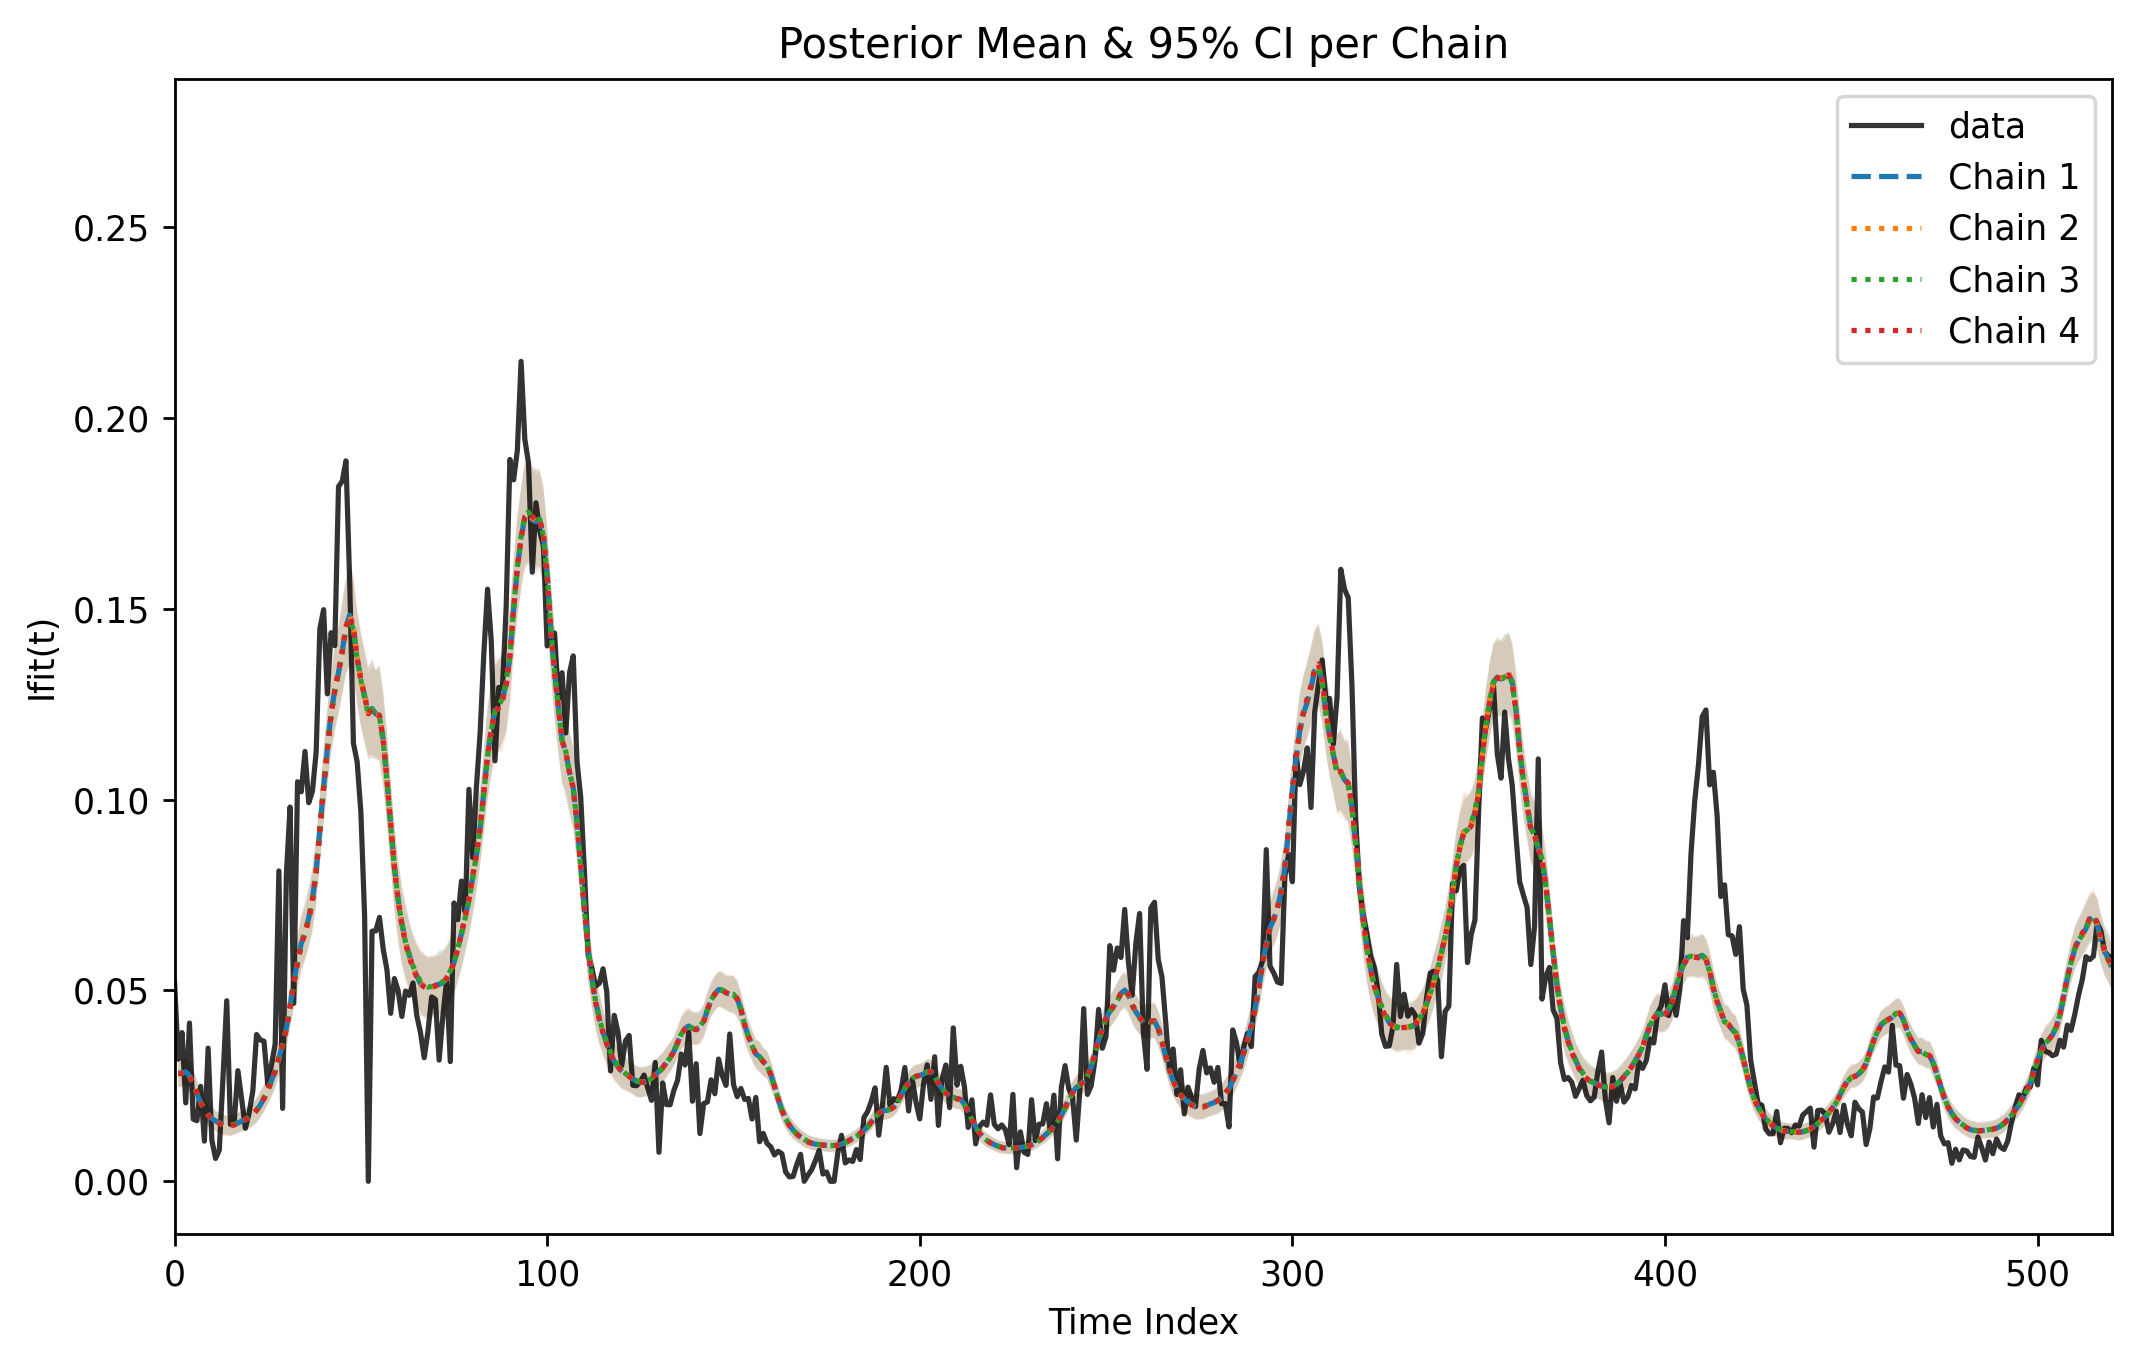

In [14]:
time_idx = np.arange(1, S_draws_per_chain.shape[2] + 1)

plt.figure(figsize=(10, 6), dpi=250)

plot_data = True

excluded_chains = []
#excluded_chains = [1,3,2]


if plot_data:
    plt.plot(df['value'], label="data", color='black', alpha=0.8)

for c in range(num_chains):
    if not (c+1 in excluded_chains):
        chain_data = S_draws_per_chain[c, :, :]  # shape: (draws_per_chain, time_points)
        chain_mean = chain_data.mean(axis=0)
        chain_lower = np.percentile(chain_data, 2.5, axis=0)
        chain_upper = np.percentile(chain_data, 97.5, axis=0)
        print(f"Max of chain {c+1}: {np.max(chain_mean)}")
    
        if c+1 < num_chains/2:
            plt.plot(time_idx, chain_mean, "--", label=f'Chain {c+1}')
        else:
            plt.plot(time_idx, chain_mean, ":", label=f'Chain {c+1}')
        plt.fill_between(time_idx, chain_lower, chain_upper, alpha=0.1)

plt.xlabel("Time Index")
plt.ylabel(f"{var}(t)")
plt.title("Posterior Mean & 95% CI per Chain")
plt.legend()
plt.xlim(0, 10*52)

In [15]:
chain_of_interest = 1
df_draws = fit.draws_pd()

for var in ['S0', 'logx_I0', 'sigma_obs', 'logrho']:
    c = chain_of_interest-1
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    mm = np.mean(chain_subset[var].values)
    sd = np.std(chain_subset[var].values)
    print(f"{var}: {mm}")
    if var == "logx_I0":
        print(f"\t(I0 = {10**mm * np.mean(chain_subset["S0"].values)})")
    if var=='delta':
        print(f"1/(mean({var})) = {1/mm:.3f} weeks = {(1/52)*1/mm:.3f} years")
        print(f"+ standard deviation: 1/(mean({var})) = {1/(mm+sd):.3f} weeks = {(1/52)*1/(mm+sd):.3f} years")
        print(f"- standard deviation: 1/(mean({var})) = {1/(mm-sd):.3f} weeks = {(1/52)*1/(mm-sd):.3f} years")

S0: 0.57363234
logx_I0: -2.5984444
	(I0 = 0.00144606970509607)
sigma_obs: 0.017727643500000004
logrho: -1.7152819666666665


# Pairwise posterior plots

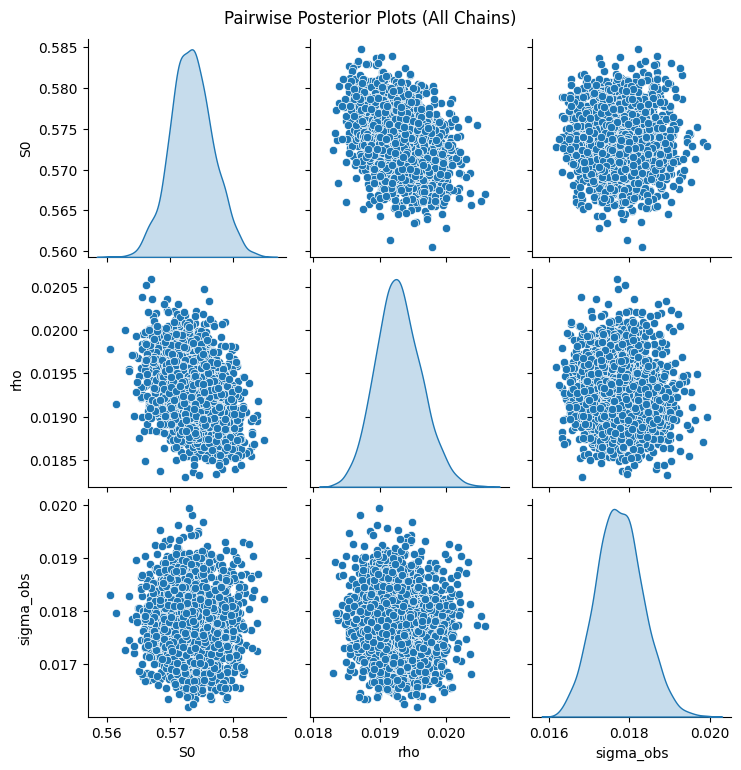

In [16]:
df_draws = fit.draws_pd()

params_of_interest = ["S0", "rho", "sigma_obs"] 

df_subset = df_draws[params_of_interest]

sns.pairplot(df_subset, diag_kind="kde")
plt.suptitle("Pairwise Posterior Plots (All Chains)", y=1.02)
plt.show()


In [17]:
# Per-chain

In chain 1, averages were: sigma_obs : 0.017727643500000004,   rho : 0.019265530000000003  (mean product: 0.00034150300494643335)


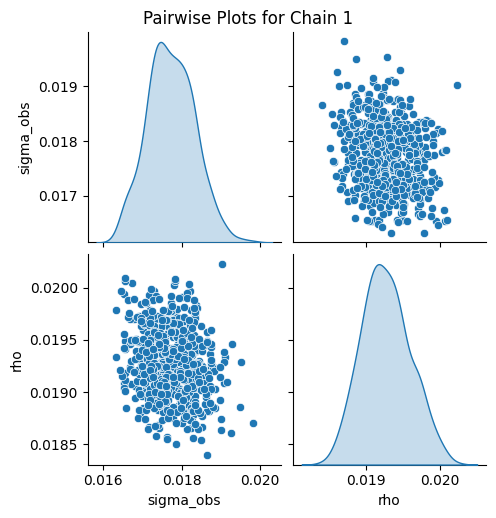

In chain 2, averages were: sigma_obs : 0.01775559566666667,   rho : 0.019288989833333332  (mean product: 0.00034247401231811663)


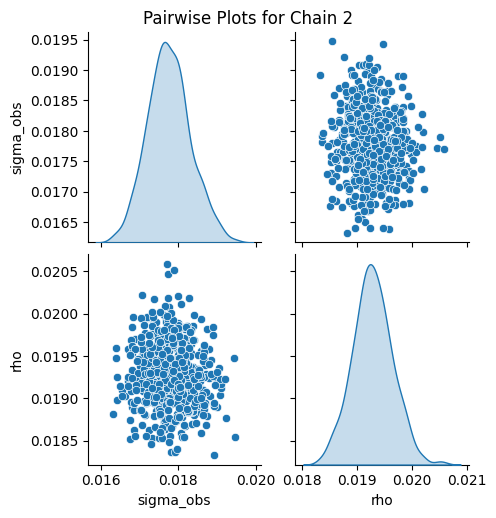

In chain 3, averages were: sigma_obs : 0.017779911333333336,   rho : 0.019285554833333333  (mean product: 0.00034289473264966663)


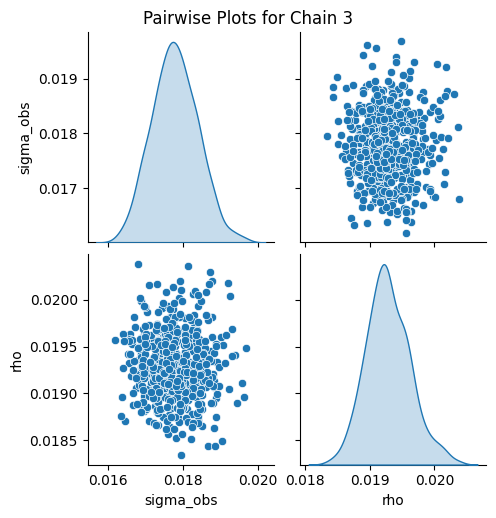

In chain 4, averages were: sigma_obs : 0.017765535666666665,   rho : 0.019297304833333334  (mean product: 0.00034283019727083337)


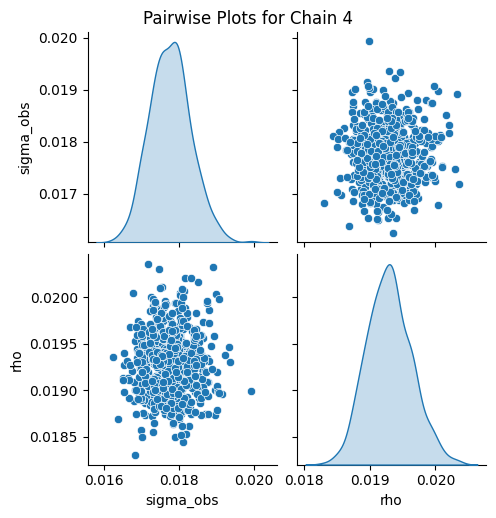

In [18]:
params_of_interest = ["sigma_obs", "rho"]
#params_of_interest = ["S0", "I0"]
#params_of_interest = ["betaphase", "delta"]
#params_of_interest = ["beta0", "rho"]

for c in range(num_chains):
    chain_subset = df_draws.iloc[c*draws_per_chain:(c+1)*draws_per_chain]
    # chain_subset now holds rows for chain c
    p1 = params_of_interest[0]
    p2 = params_of_interest[1]
    mp = np.mean(chain_subset[params_of_interest[0]].values*chain_subset[params_of_interest[1]].values)
    print(f"In chain {c+1}, averages were: {params_of_interest[0]} : {chain_subset[params_of_interest[0]].mean()},   {params_of_interest[1]} : {chain_subset[params_of_interest[1]].mean()}  (mean product: {mp})")
    for p in [p1, p2]:
        if p in ["delta"]:
            print(f"1/{p} = {1/np.mean(chain_subset[p].values)}")
    sns.pairplot(chain_subset[params_of_interest], diag_kind="kde")
    plt.suptitle(f"Pairwise Plots for Chain {c+1}", y=1.02)
    plt.show()
